## Imports

In [1]:
import numpy as np
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, HMC, Predictive
from numpyro.infer.initialization import init_to_value

import jax
from jax import random, vmap
import jax.numpy as jnp
from jax.nn import relu

from jax import config

config.update("jax_enable_x64", True)

display(jax.devices())

import pickle

import os
import sys

sys.path.append(os.path.abspath(os.path.join('..')))

from src.models.NumPyroModels import NumPyroModel
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.data_utils import *
from src.utils.numpyro_utils import *


%load_ext autoreload
%autoreload 2

%matplotlib inline

[cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]

## Creating Data Set

In [2]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    pass
    #plot_data_generation_diff(etas_train)

/home/cgrogan/UncertaintyQuantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


## Scaling Data and Converting

In [3]:
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_scaled_test = x_scaler.transform(etas_test)
y_scaled_test = y_scaler.transform(gs_test)

x_train = jnp.array(x_scaled_train, dtype=jnp.float64)
y_train = jnp.array(y_scaled_train, dtype=jnp.float64)

2024-08-08 15:23:42.342168: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Network and HMC parameters

In [4]:
hmc_checkpoints = "../Model_Checkpoints/HMC/"

#gold_step_size = 55e-5
#gold_trajectory_length = 1.6501

step_size = 5e-5
trajectory_length = 0.01
num_steps = int(np.ceil(trajectory_length // step_size))
print("Number of Steps: ", num_steps)

init_dict = pickle.load(open(hmc_checkpoints+"HMC_Initialize_large.pkl", "rb"))

for key, value in init_dict.items():
    print(key)
    init_dict[key] = jnp.array(value.astype(jnp.float64).T)
    print(init_dict[key].shape)

net_params = {
    "input_dim": 2,
    "output_dim": 3,
    "hidden_dim": 20,
    "num_layers": 4,
    "data_size": len(x_train),
    "layer_prior_scale": 5.0,
}

hmc_params = {
    "model": NumPyroModel(**net_params),
    "step_size": step_size,
    "trajectory_length": trajectory_length,
    "adapt_step_size": False,
    "dense_mass": True,
    "init_strategy": init_to_value(values=init_dict),
}

mcmc_params = {
    "num_warmup": 10,
    "num_samples": 10,
    "num_chains": 1
}



Number of Steps:  199
w1
(2, 20)
b1
(20,)
w2
(20, 20)
b2
(20,)
w3
(20, 20)
b3
(20,)
w4
(20, 3)
b4
(3,)


## Run Training

In [9]:
print(hmc_params["model"])

kernel = HMC(**hmc_params)

mcmc = MCMC(kernel, **mcmc_params)

rng_key = random.PRNGKey(0)

mcmc.run(rng_key, x_train, y_train)

Layer 1: 2 -> 20
Layer 2: 20 -> 20
Layer 3: 20 -> 20
Layer 4: 20 -> 3



sample: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it, 200 steps of size 5.00e-05. acc. prob=1.00]


## Saving MCMC Run

In [10]:
save_prefix = f"HMC_{mcmc_params['num_warmup']}_{mcmc_params['num_samples']}_{num_steps}"

save_numpyro_mcmc(mcmc, hmc_checkpoints, save_prefix)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]     -0.34      0.01     -0.34     -0.36     -0.33     12.12      1.18
     b1[1]      0.14      0.01      0.13      0.12      0.17      5.64      1.41
     b1[2]     -4.07      0.02     -4.08     -4.09     -4.04     11.85      1.31
     b1[3]     -0.12      0.01     -0.12     -0.13     -0.12      7.41      1.42
     b1[4]      0.17      0.01      0.17      0.16      0.19      6.25      1.19
     b1[5]     -0.09      0.03     -0.07     -0.15     -0.07      3.19      1.71
     b1[6]     -0.09      0.02     -0.08     -0.13     -0.08      3.04      1.74
     b1[7]     -0.86      0.01     -0.87     -0.88     -0.84      9.49      1.33
     b1[8]     -0.01      0.01     -0.00     -0.03      0.00      9.31      1.41
     b1[9]      0.51      0.01      0.51      0.50      0.52     13.17      1.46
    b1[10]      0.15      0.01      0.15      0.14      0.17      8.53      1.12
    b1[11]      0.62      0

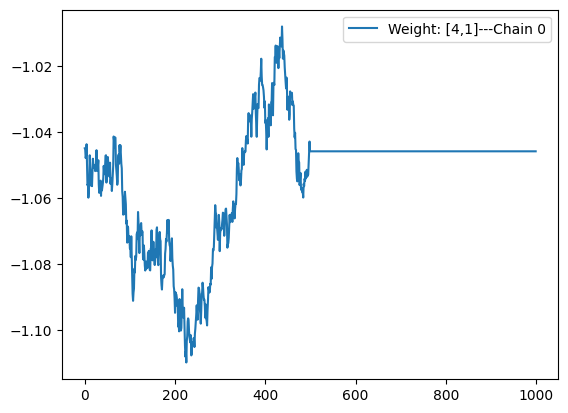

In [5]:
saves = "../Model_Checkpoints/HMC/HMC_1000_1000_6000"
num_samples = 2
samples = []

samples_dict = pickle.load(open(saves+'_samples.pkl', 'rb'))
last_state = pickle.load(open(saves+'_last_state.pkl', 'rb'))


for k, v in samples_dict.items():
    samples_dict[k] = jnp.expand_dims(v, 0)

# exclude samples
for key, value in samples_dict.items():
    print(key, value.shape)
    samples_dict[key] = jnp.concat([value[:,:500, ...], value[:,999:, ...]], axis=1)

kernel = HMC(**hmc_params)

mcmc = MCMC(kernel, **mcmc_params)

mcmc._states = {'z': samples_dict}
mcmc._last_state = last_state

print(mcmc.print_summary())


for key, value in samples_dict.items():
    print(key, value.shape)

import matplotlib.pyplot as plt
plt.rcParams['text.usetex']= False

params = samples_dict['w1']

ind1 = 4
ind2 = 1
for i in range(1):
    plt.plot(params[0, :, ind1, ind2], label=f"Weight: [{ind1},{ind2}]---Chain {i}")

plt.legend()
plt.show()

## Predictions

/home/cgrogan/UncertaintyQuantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))
/var/tmp/pbs.2057226.polaris-pbs-01.hsn.cm.polaris.alcf.anl.gov/ipykernel_2187714/3654297244.py:17: UserWarning: Sample's batch dimension size 1000 is different from the provided 10 num_samples argument. Defaulting to 1000.
  predictive = Predictive(model_test, posterior_samples=mcmc.get_samples(), num_samples=10)


0.009490749236072248


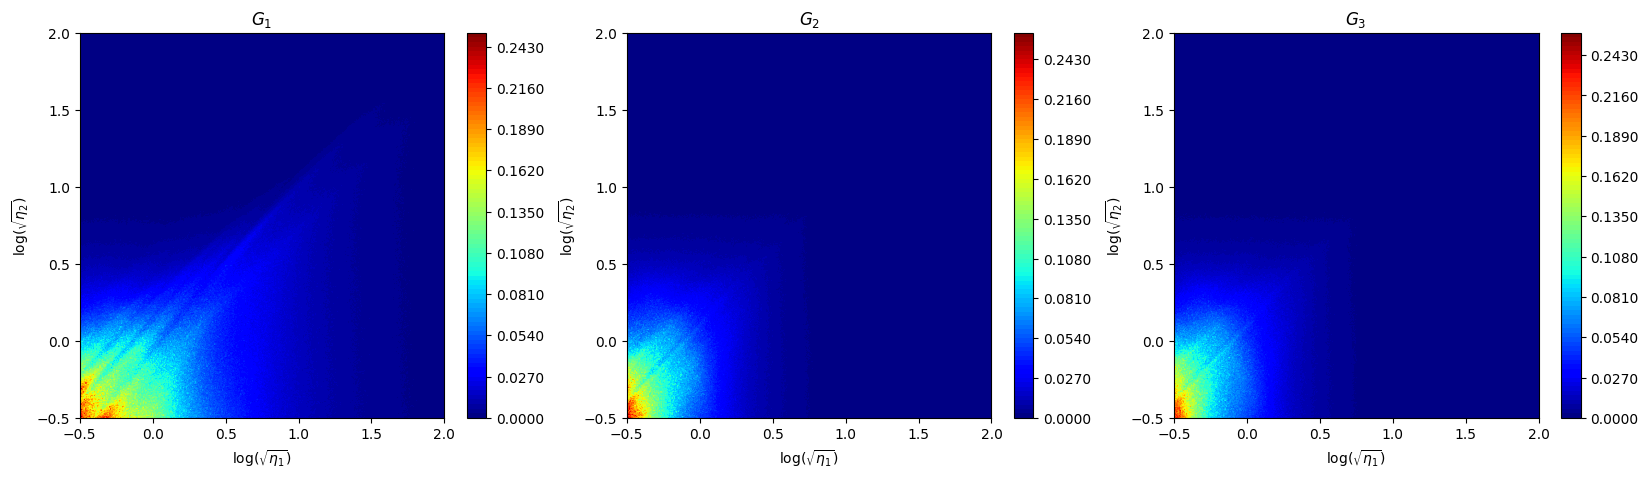

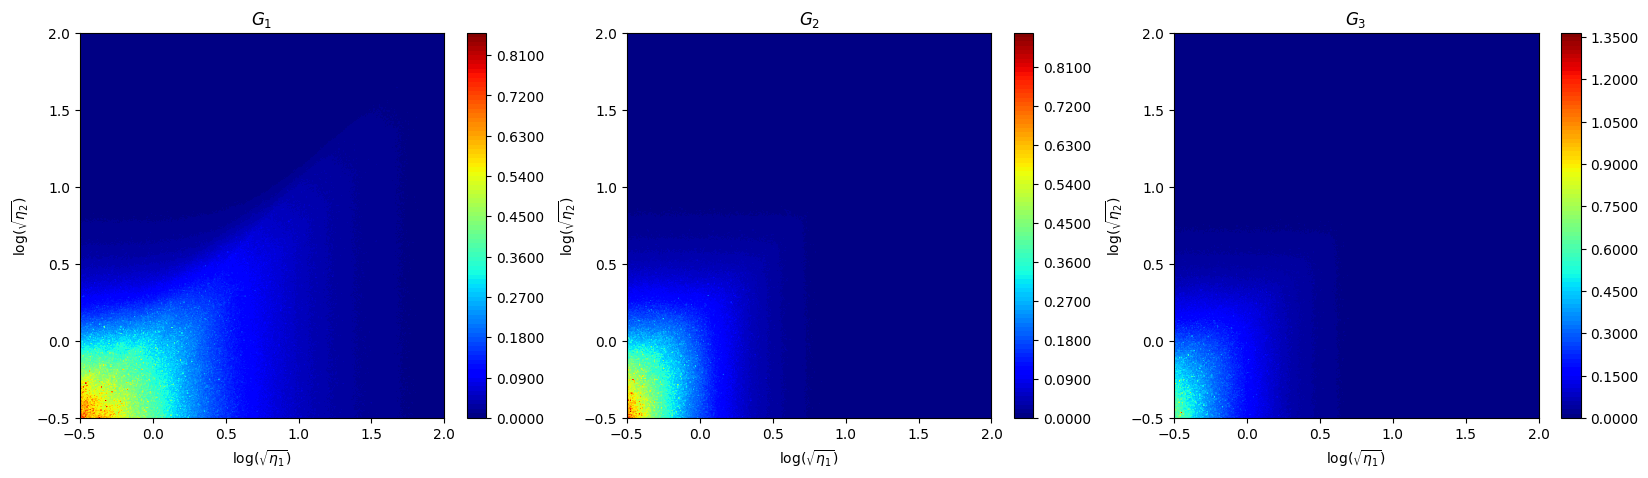

In [6]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG")
etas, G_s = gen(eta1, eta2)

etas = jnp.array(etas)
target = jnp.array(G_s)

model_test = NumPyroModel(**net_params)
model_test.data_size = etas.shape[0]

etas = x_scaler.transform(etas)

predictive = Predictive(model_test, posterior_samples=mcmc.get_samples(), num_samples=10)

pred = np.array(predictive(random.PRNGKey(0), etas)['Y'])

for i in range(pred.shape[0]):
    pred[i] = y_scaler.inverse_transform(pred[i])

pred_mean = jnp.mean(pred, axis=0)
pred_std = jnp.std(pred, axis=0)

del pred
del predictive

print(jnp.mean(jnp.abs(target - pred_mean)))

target = target.T.reshape(3, dim, dim)
pred_mean = pred_mean.T.reshape(3, dim, dim)
pred_std = pred_std.T.reshape(3, dim, dim)

plot_heat_map_3D(x_grid, y_grid, np.abs(pred_mean - target))

plot_heat_map_3D(x_grid, y_grid, pred_std)